# Approximate quantile calculation

The article ["A Survey of Approximate Quantile Computation on Large-Scale Data"](https://arxiv.org/pdf/2004.08255.pdf) describes several algorithms on calculating quantiles over streaming or distributed data. I will implement the Greenwald - Khanna algorithm (referenced as GK01 in the article). This is an algorithm for calculating the approximate quantiles over a streaming data (data that can be added at any time). 

Recall: an approximate $\phi$ - quantile with an an $\epsilon$ error is any observation from data that belongs to $[r - \epsilon n; r + \epsilon n]$, where $r = \lfloor\phi n \rfloor$.

## Abstract implementation

In [1]:
from typing import List

class BasicQuantileAlgorithm:
    """
    Abstract class for quantile computing algorithm
    """
    
    def __init__(self) -> None:
        """
        Initializer for algorithm
        """
    
    def compute_quantile(self, q) -> float:
        """
        Implementation of some quantile algorithm
        """
        raise NotImplementedError('compute_quantile is not implemented')
    
    def add_item(self, item):
        """
        Adds an item to the existing data
        """
    
    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing data
        """
    
    def compute(self, q) -> float:
        assert 0.0 <= q <= 1.0, f"q should be in [0;1]. Got {q}"
        """
        Compute the q-th quantile
        
        Hides implementation of _compute_quantile. 
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return self.compute_quantile(q)
    
    # NOTE: multi_compute is just a basic function
    # for computing multiple quantile with one function call. 
    # This can be modified, so that multiple quantiles
    # calculation become efficient. 
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return [self.compute(q) for q in qs]

## Numpy implementation

In [2]:
import numpy as np

class NumpyQuantileAlgorithm(BasicQuantileAlgorithm):
    """
    Example of quantile algorithm
    
    This algorithm implementation is 
    based on the numpy.quantile. 
    """
    def __init__(self):
        """
        Initializer of the class. 
        
        It initializes self.data with empty list
        """
        self.data = []
    
    def add_item(self, item):
        """
        Adds an item to the existing data
        """
        self.data.append(item)
    
    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing data
        """
        self.data += items
    
    def compute(self, q) -> float:
        """
        Compute the q-th quantile
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return np.quantile(self.data, q)
    
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return list(self.compute_quantile(qs))

## Greenwald - Khanna Algorithm implementation

In [3]:
from dataclasses import dataclass
import bisect

@dataclass
class _Tuple:
    value: float
    g: int
    delta: int

    def __lt__(self,other):
        return self.value < other.value

class GreenwaldKhannaQuantileAlgorithm(BasicQuantileAlgorithm):

    def __init__(self,error) -> None:
        assert 0.0 <= error <= 1.0, f"q should be in [0;1]. Got {error}"

        self.tuples: list[_Tuple] = []
        self.error = error
        self.n = 0

    
    def add_item(self, item):


        if self.n % np.floor(1/(2* self.error)) == 0:
            self._compress();


        t = _Tuple(item, g=1, delta=np.floor(2 * self.error * self.n))
        
        if(self.n == 0):
            self.tuples.append(t)
        else:
            if item < self.tuples[0].value or item >= self.tuples[-1].value:
                t.delta = 0
                bisect.insort_right(self.tuples, t)
            else:
                index = bisect.bisect_right(self.tuples, t)
                t.delta = self.tuples[index].g + self.tuples[index].delta - 1
                self.tuples.insert(index, t)
            
        

        self.n +=1

    def compute(self, q) -> float:
        assert 0.0 <= q <= 1.0, f"q should be in [0;1]. Got {q}"
        assert self.n > 0, "No elements added yet"
        

        r = np.floor(q * self.n)

        if r == 0:
            return self.tuples[0].value
        
        if q == 1 or r + self.error * self.n >= self.n:
            return self.tuples[-1].value


        r_min = 0
        for i,t in enumerate(self.tuples):
            r_min += t.g
            if r_min + t.delta > r + self.error * self.n:
                return self.tuples[i-1].value
        

    def _compress(self):
        i = len(self.tuples) - 1
        while(i >= 2):
            j = i - 1

            r_min = self.tuples[i].g + self.tuples[j].g
            while (j >=1 and r_min + self.tuples[i].delta < 2 * self.error * self.n):
                j-=1
                r_min += self.tuples[j].g
            
            new_g = r_min - self.tuples[j].g
            j+=1


            if j < i:
                self.tuples[i].g = new_g
                for m in range(i-1,j-1,-1):
                    self.tuples.pop(m)

            i = j - 1


    def add_multiple_items(self, items):
        for item in items:
            self.add_item(item)
    

## Description of an algorithm

I implemented the Greenwald-Khanna algorithm that is mentioned as GK01 in the assignment paper.

Firstly, let us denote $r_{min}(v)$ and $r_{max}(v)$ as respectively lower and upper bounds on the ranks of $v$ among
the $n$ observations got so far. 

The algorithm introduces the new data structure named `Summary`. It consists of the tuples $t_i$ = $(v_i, g_i, \Delta_i)$, where $v_i$ - a value that corresponds to one
of the elements in the data sequence seen thus far,  $g_i$ = $r_{min}(v_i) - r_{min}(v_{i-1})$ and $\Delta_i$ = $r_{max}(v_{i}) - r_{min}(v_{i})$. The tuples are always kept sorted by $v_i$ in ascending order. Note that $v_0$ and $v_{s-1}$ represent the minimum and maximum values of data, where $s$ - number of tuples stored.

It easy to prove by simple substitution that $r_{min} (v_i) = \sum_{j=0}^i g_j$ and $r_{max} (v_i) = \sum_{j=0}^i g_j + \Delta_i$. So, the tuple $t_i$ stores the bounds on ranks that $v_i$ represents.

As it is proven in the original paper of algorithm ([Link](http://infolab.stanford.edu/~datar/courses/cs361a/papers/quantiles.pdf) pg. 60 Corollary 1), given the Summary `S` at any time $n$, if all for all $t_i$ we hold $g_i + \Delta_i \le 2\epsilon n$, we can answer any $\phi$ - quantile query with $\epsilon$ precision. In other words, to satisfy the approximation asuumption with $\epsilon$ error, at every time we need to keep tuples in such way that we cover all values of original data set and keep $v_i \in [r - \epsilon n; r + \epsilon n]$, where $r = \lfloor\phi n \rfloor$.

Now, let's go to the algorithm itself.

#### Quantile operation

The main thing we want to get is the $\phi$ quantile. Firstly, we need to calculate $r = \lfloor\phi n \rfloor$. Secondly, we need to check for border cases:
- If we get $r = 0$, we just return the first element (minimum) $v_0$ by the definition of zero-quantile.
- If we get $\phi = 1$, we just return the last element (maximum) $v_{s-1}$.
- If it appears that the upper bound of approximation $r + \epsilon n \ge n$, we return the last element as well because the approximation conditions hold.

In other cases we proceed the following strategy. We find (by iterating through tuples) the smallest $i$ such that for $t_i$: $r_{max}(v_i) \gt r + \epsilon n$, which means that this tuple may violate the approximation criteria. Then, we return the value $v_{i-1}$.

#### Insertion operation

To insert a value $v$ into our `Summary`, we need to find $i$ such that $v_{i-1} \le v \lt v_i$. Then we insert a tuple $(v, 1, g_i + \Delta_i - 1)$ between $t_{i-1}$ and $t_i$. If $v$ is the new minimum or maximum instead of $(v, 1, g_i + \Delta_i - 1)$ we insert $(v,1,0)$ in the beggining or the end respectively. Doing insertion in such way we always hold the structure correct.

#### Compression

In order to decrease space taken by `Summary` before every $\frac 1{2\epsilon}$ insertion we compress the data.

The algorithm for compression is the following. By taking $i$ as last index of the tuples list, we find the longest subarray $t_j, ..., t_i$ such that $t_j + ... + t_i + \Delta_i \lt 2\epsilon n$. If this subarray contains more than one tuple ($j \lt i$), we replace $t_j, ..., t_i$ by new tuple $(v_i,t_j + ... + t_i,\Delta_i)$. Then we continue doing the same for $i = j - 1$ until $i$ reaches 1. By doing that we merge tuples with "low range" into tuples with "larger range" without violating the criterias with the benefit of freeing up space.

## Comparison of performance

Below, we will see how the approximate algorithm works in comparison with the numpy implementation. We will watch on memory and time consumtion.

### Statistics counters

The below code copy-pasted from https://gist.github.com/durden/0b93cfe4027761e17e69c48f9d5c4118. It just calculates size of object recursively. I need this as default `getsizeof()` just returns the size of an object without its inner data.

In [4]:
import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects"""

    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()

    obj_id = id(obj)
    if obj_id in seen:
        return 0

    seen.add(obj_id)

    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])

    return size

In [5]:
import time

def count_statistics(algo, quantile):
    start_time = time.time()
    end_time = time.time()
    return end_time - start_time, get_size(algo)

### Generating data and calculating performance

Here, we iterate for `iterations` times and on each one (let`s call it timestamp) generate the random data, put it into two algorythms (Approximate and numpy) and then calculating the random quantile on both algorithms with measuring and storing performances for further plotting.

In [6]:
import random

iterations = 200000 # Number of elements to be added to the data structures during capturing performance
statistics_capture_step = 1000 # Number that defines how frequent we will measure performance (e.g 500 means every 500th addition)

error = 0.005 # maximum error for approximate algorithm

numpy_algo = NumpyQuantileAlgorithm()
approx_algo = GreenwaldKhannaQuantileAlgorithm(error=error)

numpy_times = []
numpy_spaces = []

approx_times = []
approx_spaces = []

n_tuples = []


for i in range(iterations):
    new_value = np.random.normal()
    numpy_algo.add_item(new_value)
    approx_algo.add_item(new_value)

    if(i % statistics_capture_step == 0):
        print(f"Iteration: {i} / {iterations}")

        q = random.randint(0,1000)/1000

        np_time, np_space = count_statistics(numpy_algo,q)
        numpy_times.append(np_time)
        numpy_spaces.append(np_space)    
        appr_time, appr_space = count_statistics(approx_algo,q)
        approx_times.append(appr_time)
        approx_spaces.append(appr_space)



Iteration: 0 / 200000
Iteration: 1000 / 200000
Iteration: 2000 / 200000
Iteration: 3000 / 200000
Iteration: 4000 / 200000
Iteration: 5000 / 200000
Iteration: 6000 / 200000
Iteration: 7000 / 200000
Iteration: 8000 / 200000
Iteration: 9000 / 200000
Iteration: 10000 / 200000
Iteration: 11000 / 200000
Iteration: 12000 / 200000
Iteration: 13000 / 200000
Iteration: 14000 / 200000
Iteration: 15000 / 200000
Iteration: 16000 / 200000
Iteration: 17000 / 200000
Iteration: 18000 / 200000
Iteration: 19000 / 200000
Iteration: 20000 / 200000
Iteration: 21000 / 200000
Iteration: 22000 / 200000
Iteration: 23000 / 200000
Iteration: 24000 / 200000
Iteration: 25000 / 200000
Iteration: 26000 / 200000
Iteration: 27000 / 200000
Iteration: 28000 / 200000
Iteration: 29000 / 200000
Iteration: 30000 / 200000
Iteration: 31000 / 200000
Iteration: 32000 / 200000
Iteration: 33000 / 200000
Iteration: 34000 / 200000
Iteration: 35000 / 200000
Iteration: 36000 / 200000
Iteration: 37000 / 200000
Iteration: 38000 / 200000

### Results

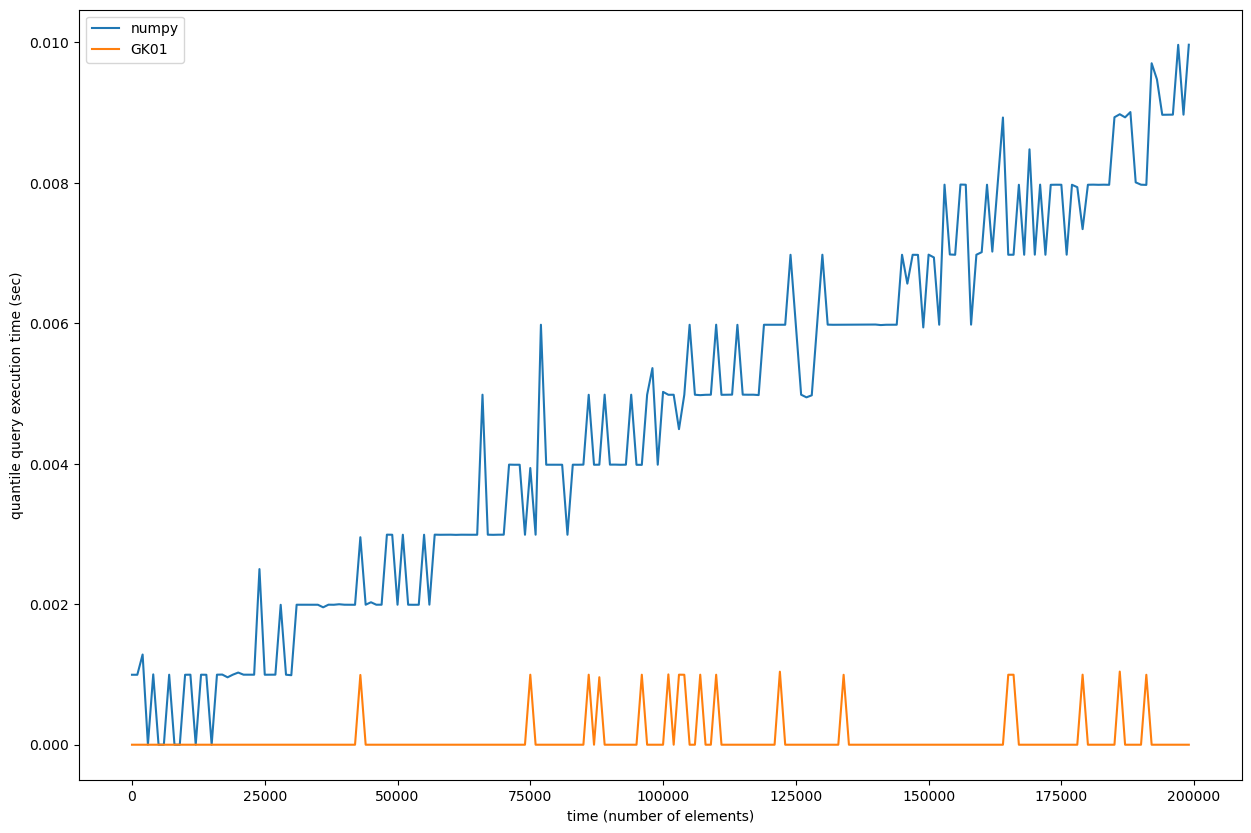

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.plot(range(0,iterations,statistics_capture_step),numpy_times,label="numpy")
plt.plot(range(0,iterations,statistics_capture_step),approx_times,label="GK01")
plt.xlabel("time (number of elements)")
plt.ylabel("quantile query execution time (sec)")
plt.legend()
plt.show()

It is obviously seen that numpy algorithm has at average linear time of calculating quantiles while approximate algorithm has something that seems like a constant. Though, because of nearence to the 0 value, we cannot make this conclusion. For it, we need to process more data but it it time consuming. But, we can say that approximate algorithm has a much better time performance calculating quantiles.

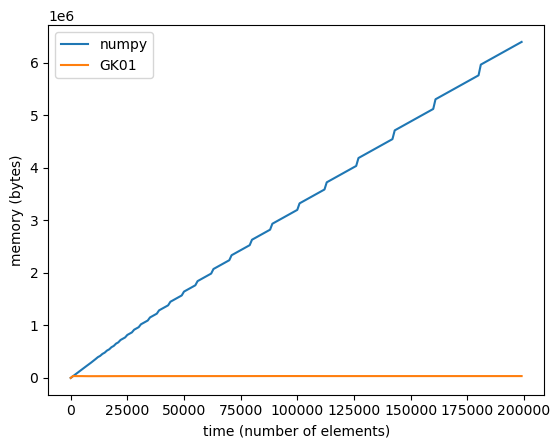

In [8]:
plt.plot(range(0,iterations,statistics_capture_step),numpy_spaces,label="numpy")
plt.plot(range(0,iterations,statistics_capture_step),approx_spaces,label="GK01")
plt.xlabel("time (number of elements)")
plt.ylabel("memory (bytes)")
plt.legend()
plt.show()

We can see that approximate algorithm is a lot better by memory consumption than a numpy, as it does not store all the data it got.

## Test

Here we will show that the approximate algorithm is working properly.

We will take some distribution (e.g normal) and see how the calculated by our algorithm quantiles behaves with the increase in sample size and whether they tend to approximate more and more the quantile function (`inverse cdf`) of the distribution.

In [9]:
import scipy.stats as st

def compare_to_inv_cdf(distribution):
    error = 0.005
    xticks_n = 1000
    graphs_n = 5

    ticks = np.array(range(xticks_n))/1000

    plt.figure(figsize=(graphs_n * 10, 10))

    inv_cdf = []
    for i in range(xticks_n):
            q = i/xticks_n
            inv_cdf.append(distribution.ppf(q))

    for index, n in enumerate([10 ** i for i in range(1,graphs_n+1)]):
        approx_values = []
        
        algo = GreenwaldKhannaQuantileAlgorithm(error=error)
        algo.add_multiple_items(distribution.rvs(size=n))

        for i in range(xticks_n):
            q = i/xticks_n
            approx_values.append(algo.compute(q))

        plt.subplot(1,graphs_n,index+1)
        plt.plot(ticks,inv_cdf,label="inverse cdf")
        plt.step(ticks, approx_values,label="GK=1")
        plt.title(f"n = {n}")
        plt.legend()

    plt.show()


### Normal distribution

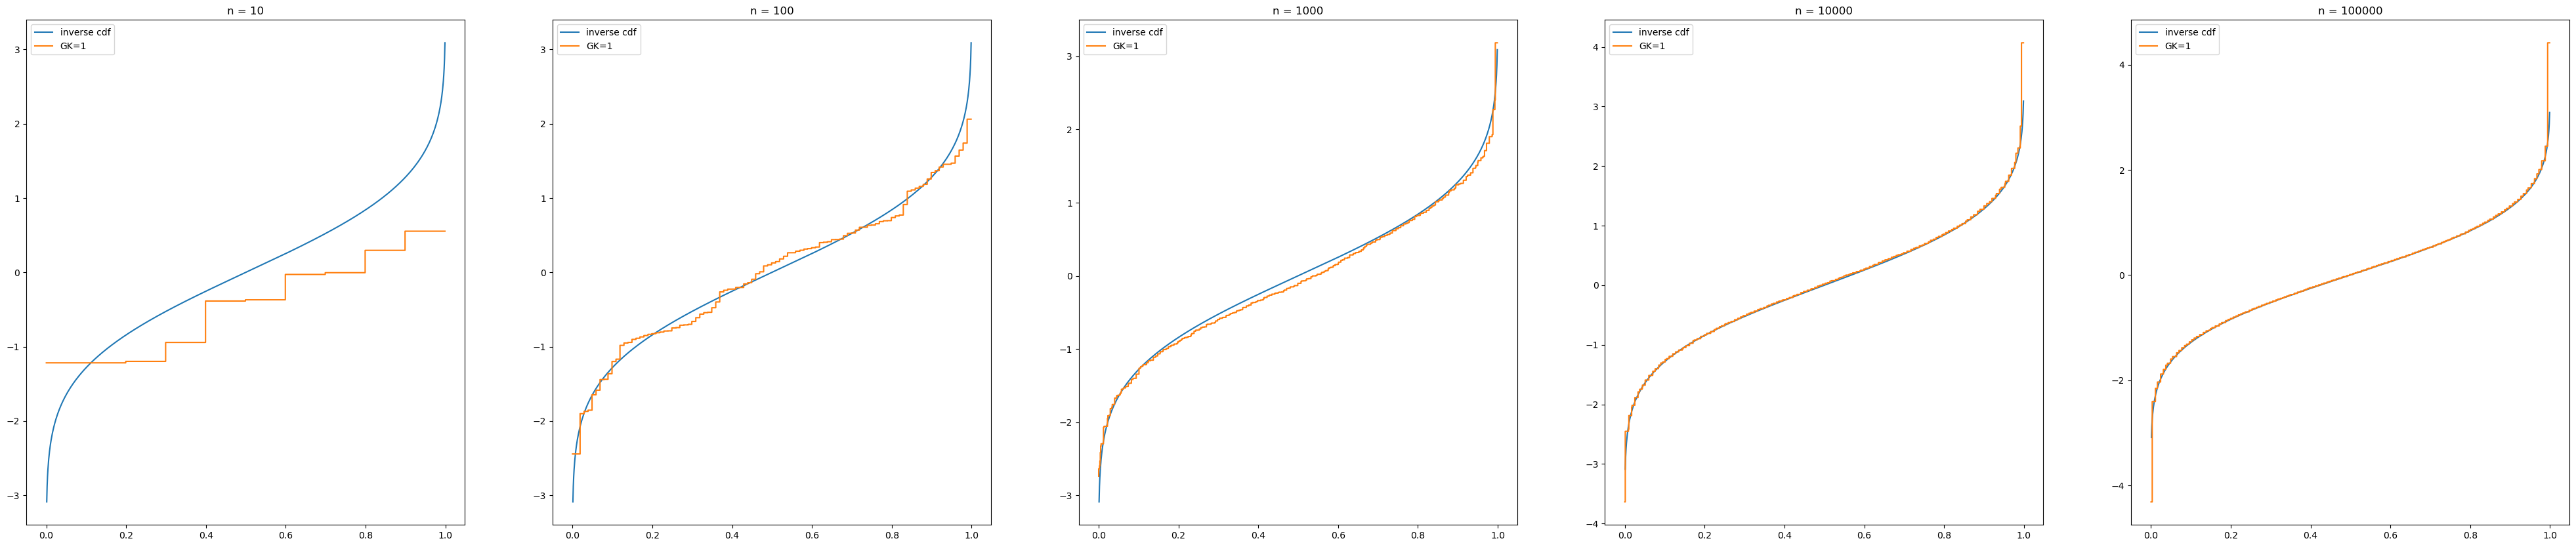

In [10]:
compare_to_inv_cdf(st.norm)

### Exponential distribution

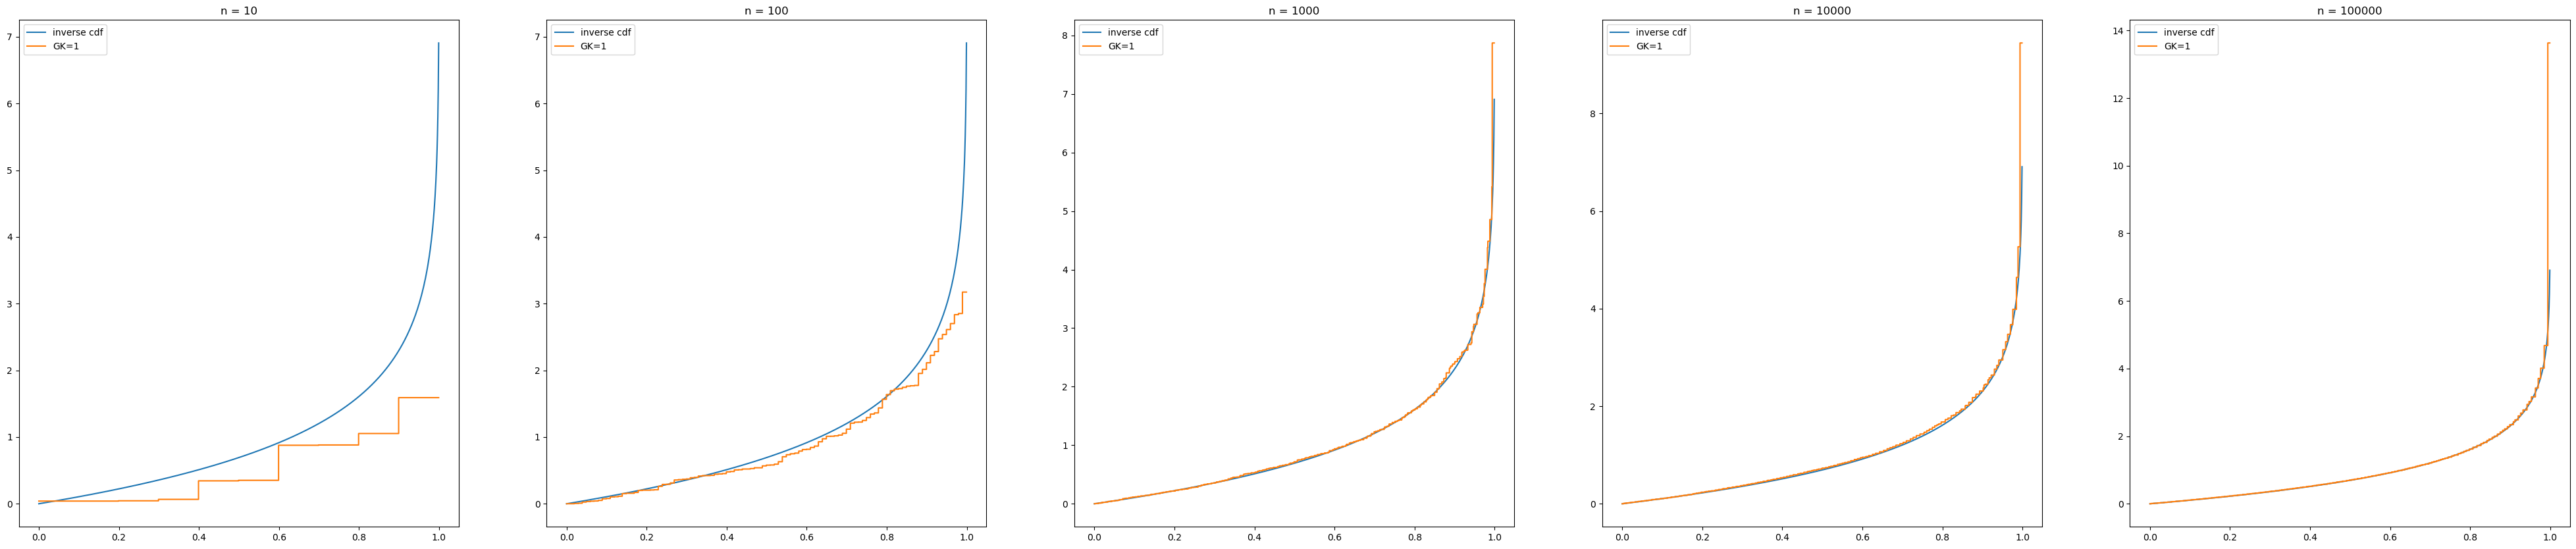

In [11]:
compare_to_inv_cdf(st.expon)


### Logistic distribution

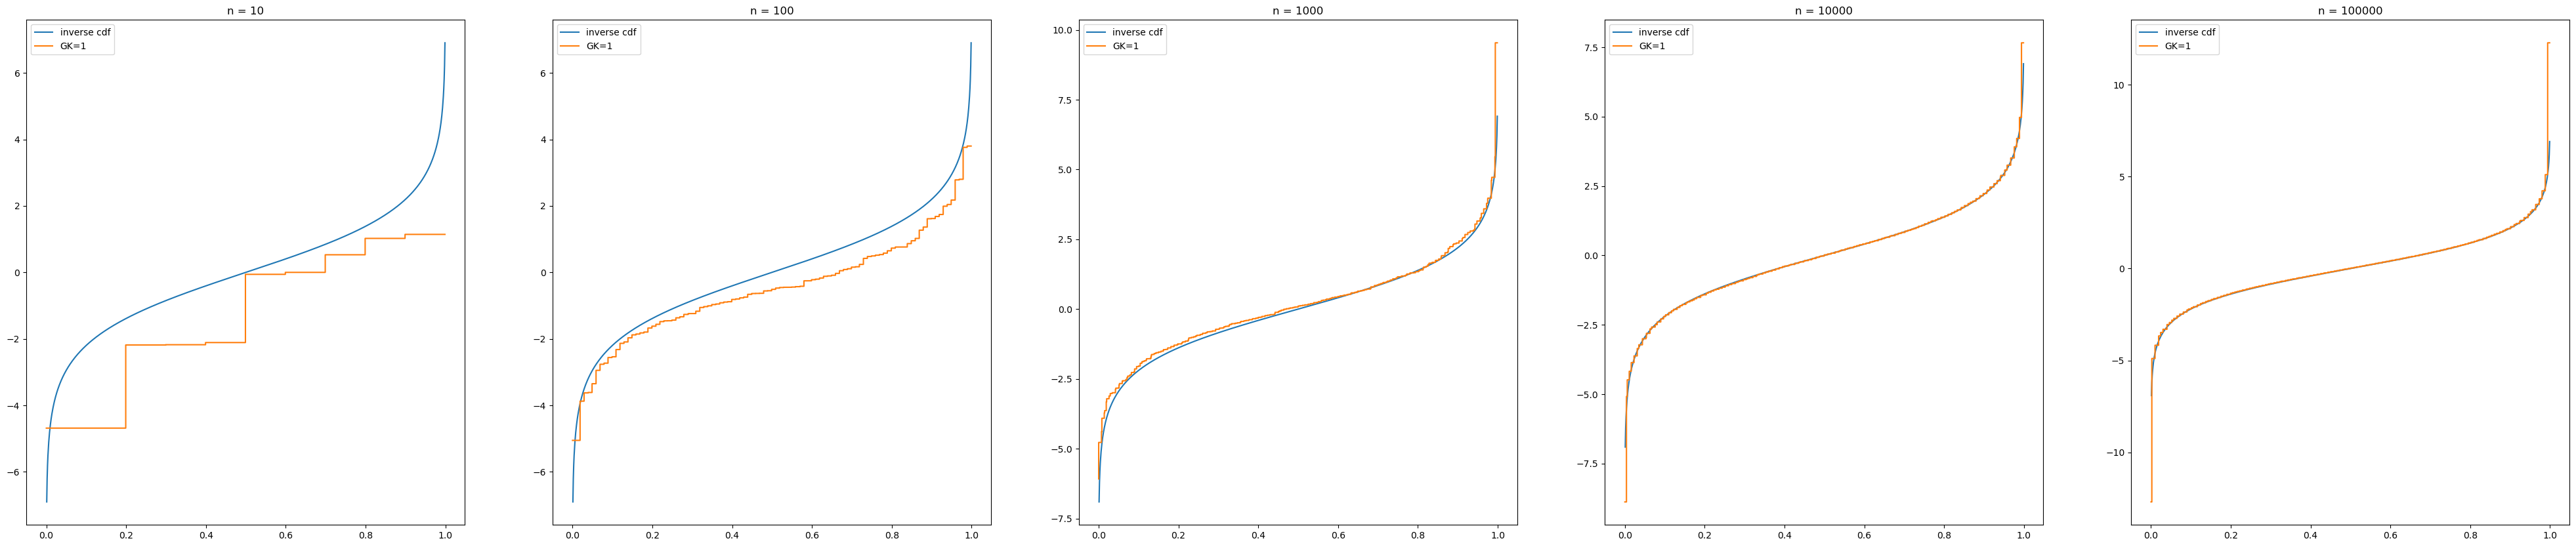

In [12]:
compare_to_inv_cdf(st.logistic)

### Poisson distribution

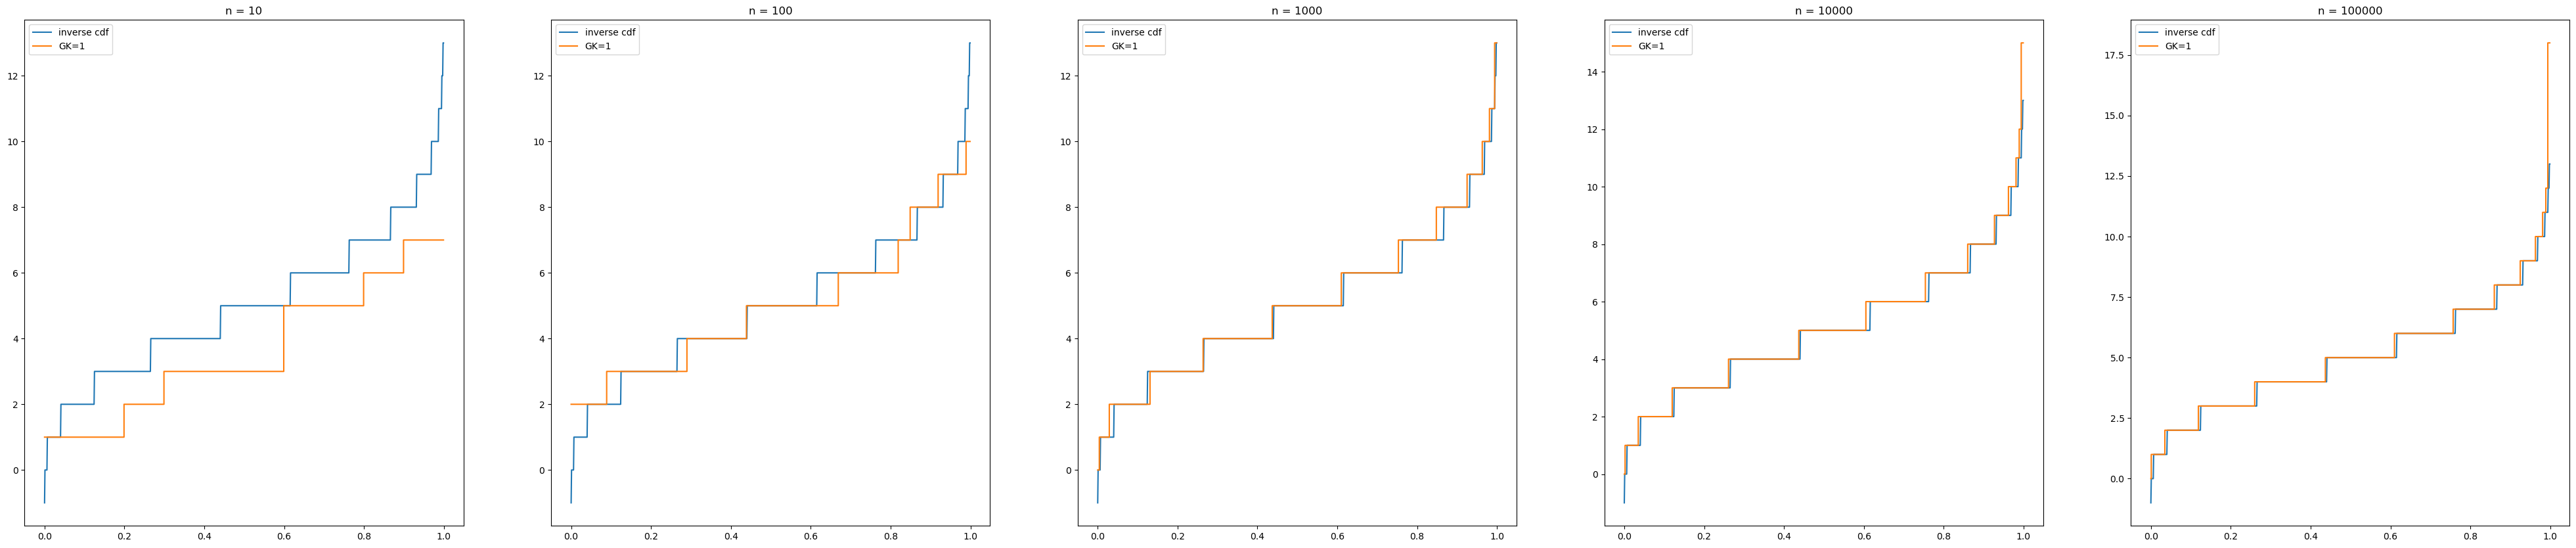

In [13]:
compare_to_inv_cdf(st.poisson(5))

We can see that while increasing the number of observations, the approximate quantiles tends to the distribution quantile function.

### Showcase


Here we will test the correctness of the approximate algorithm by using the brootforce finding of correct answers and comparing it to the approximate algorithm results. Also, we will show that the algorithm works for the purpose it is needed for: calculating quantiles for the streaming data.

So, here we go through `iters` timestamps and on each one take a random quantile. Then check if the result we got satisfies the error criterion for the approximation algorithm.

In [14]:
iters = 10000
error = 0.051

algo = GreenwaldKhannaQuantileAlgorithm(error=error)
all_data = []

def compute_and_check_correctness(quantile, data, algo):
    r = np.floor(quantile * len(data))

    low_bound = np.ceil(r - error * len(data))

    upper_bound = np.floor(r + error * len(data))

    correct_answers = []
    if r == 0:
        correct_answers = [data[0]]
    elif quantile == 1:
        correct_answers = [data[-1]]
    else:
        for j in range(int(low_bound), min(len(data)+1, int(upper_bound + 1))):
            correct_answers.append(data[j-1])

    algo_result = algo.compute(quantile)

    return algo_result, algo_result in correct_answers, (min(correct_answers), max(correct_answers))

value_1 = random.randint(0,100000)
all_data.append(value_1)
algo.add_item(value_1)

correct_n = 0
for i in range(iters):
    new_value = np.random.normal()
    bisect.insort_right(all_data,new_value)
    algo.add_item(new_value)

    q = random.randint(0,1000)/1000

    value, correct,answers_range = compute_and_check_correctness(q, all_data,algo)

    if correct:
        correct_n+=1

    print(f"iteration {i} (n = {i + 2}): {q} quantile: got {value}, correct range [{answers_range[0]} ; {answers_range[1]}]." )
    
print (f"{correct_n} / {iters} correct")

iteration 0 (n = 2): 0.543 quantile: got 1.4129074823226633, correct range [1.4129074823226633 ; 1.4129074823226633].
iteration 1 (n = 3): 0.748 quantile: got 1.4129074823226633, correct range [1.4129074823226633 ; 1.4129074823226633].
iteration 2 (n = 4): 0.447 quantile: got -0.2388292606179411, correct range [-0.2388292606179411 ; -0.2388292606179411].
iteration 3 (n = 5): 0.62 quantile: got 0.7219183702339997, correct range [0.7219183702339997 ; 0.7219183702339997].
iteration 4 (n = 6): 0.192 quantile: got -0.5806548182833458, correct range [-0.5806548182833458 ; -0.5806548182833458].
iteration 5 (n = 7): 0.133 quantile: got -0.5806548182833458, correct range [-0.5806548182833458 ; -0.5806548182833458].
iteration 6 (n = 8): 0.382 quantile: got -0.1380139441232516, correct range [-0.1380139441232516 ; -0.1380139441232516].
iteration 7 (n = 9): 0.636 quantile: got 0.7219183702339997, correct range [0.7219183702339997 ; 0.7219183702339997].
iteration 8 (n = 10): 0.574 quantile: got -0.